# Machine Learning - Cover Type Analysis
Kaggle competition - 80.8% accuracy

![Tree](https://th.bing.com/th/id/R.d4a2dd941fa3470114e026a831ed07fe?rik=h04wIDYs9FQbyw&riu=http%3a%2f%2fwallpapercave.com%2fwp%2f9loeW9m.jpg&ehk=B2VFZfjBxfEfYESU8z35kUdl6JzkFHIumWq85kcs6pM%3d&risl=&pid=ImgRaw&r=0)

### Table of Contents:
1. Introduction
2. Exploratory Data Analysis
3. Data Cleaning
4. Feature Engineering
5. Feature Scaling
6. ML Predictive Analytics
7. Findings

## 1. Introduction
The task of this notebook is to predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS) Region 2 Resource Information System data. Independent variables were then derived from data obtained from the US Geological Survey and USFS. The data is in raw form (not scaled) and contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.

This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.compose import (ColumnTransformer, make_column_transformer, make_column_selector)
from sklearn.pipeline import (Pipeline, make_pipeline)
from sklearn.preprocessing import (FunctionTransformer, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer)
from sklearn.impute import (SimpleImputer, KNNImputer)
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
seed = 49

In [6]:
df_train = pd.read_csv("../01 Data/train.csv")
df_test = pd.read_csv("../01 Data/test.csv")

---
## 2. Exploratory analysis

---
### 2.1 Shape of data

In [7]:
print(df_train.shape)

(15120, 56)


In [8]:
print(df_train.dtypes)

Id                                    int64
Elevation                             int64
Aspect                                int64
Slope                                 int64
Horizontal_Distance_To_Hydrology      int64
Vertical_Distance_To_Hydrology        int64
Horizontal_Distance_To_Roadways       int64
Hillshade_9am                         int64
Hillshade_Noon                        int64
Hillshade_3pm                         int64
Horizontal_Distance_To_Fire_Points    int64
Wilderness_Area1                      int64
Wilderness_Area2                      int64
Wilderness_Area3                      int64
Wilderness_Area4                      int64
Soil_Type1                            int64
Soil_Type2                            int64
Soil_Type3                            int64
Soil_Type4                            int64
Soil_Type5                            int64
Soil_Type6                            int64
Soil_Type7                            int64
Soil_Type8                      

In [9]:
pd.set_option('display.max_columns', None)
print(df_train.describe())

# No missing data for all features
# Attributes Soil_Type7 and 15 can be removed as they are constant
# Scaling might be necessary as scales are not the same for all features

                Id     Elevation        Aspect         Slope  \
count  15120.00000  15120.000000  15120.000000  15120.000000   
mean    7560.50000   2749.322553    156.676653     16.501587   
std     4364.91237    417.678187    110.085801      8.453927   
min        1.00000   1863.000000      0.000000      0.000000   
25%     3780.75000   2376.000000     65.000000     10.000000   
50%     7560.50000   2752.000000    126.000000     15.000000   
75%    11340.25000   3104.000000    261.000000     22.000000   
max    15120.00000   3849.000000    360.000000     52.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      15120.000000                    15120.000000   
mean                         227.195701                       51.076521   
std                          210.075296                       61.239406   
min                            0.000000                     -146.000000   
25%                           67.000000         

In [10]:
# Some variables might need further scaling in terms of sknewness
print(df_train.skew())

Id                                      0.000000
Elevation                               0.075640
Aspect                                  0.450935
Slope                                   0.523658
Horizontal_Distance_To_Hydrology        1.488052
Vertical_Distance_To_Hydrology          1.537776
Horizontal_Distance_To_Roadways         1.247811
Hillshade_9am                          -1.093681
Hillshade_Noon                         -0.953232
Hillshade_3pm                          -0.340827
Horizontal_Distance_To_Fire_Points      1.617099
Wilderness_Area1                        1.231244
Wilderness_Area2                        5.228781
Wilderness_Area3                        0.324594
Wilderness_Area4                        0.825798
Soil_Type1                              6.294716
Soil_Type2                              4.617019
Soil_Type3                              3.575995
Soil_Type4                              3.872721
Soil_Type5                              9.416209
Soil_Type6          

In [11]:
# All classes are equally balanced
df_train.groupby('Cover_Type').size()

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
dtype: int64

---
### 2.2 Correlation

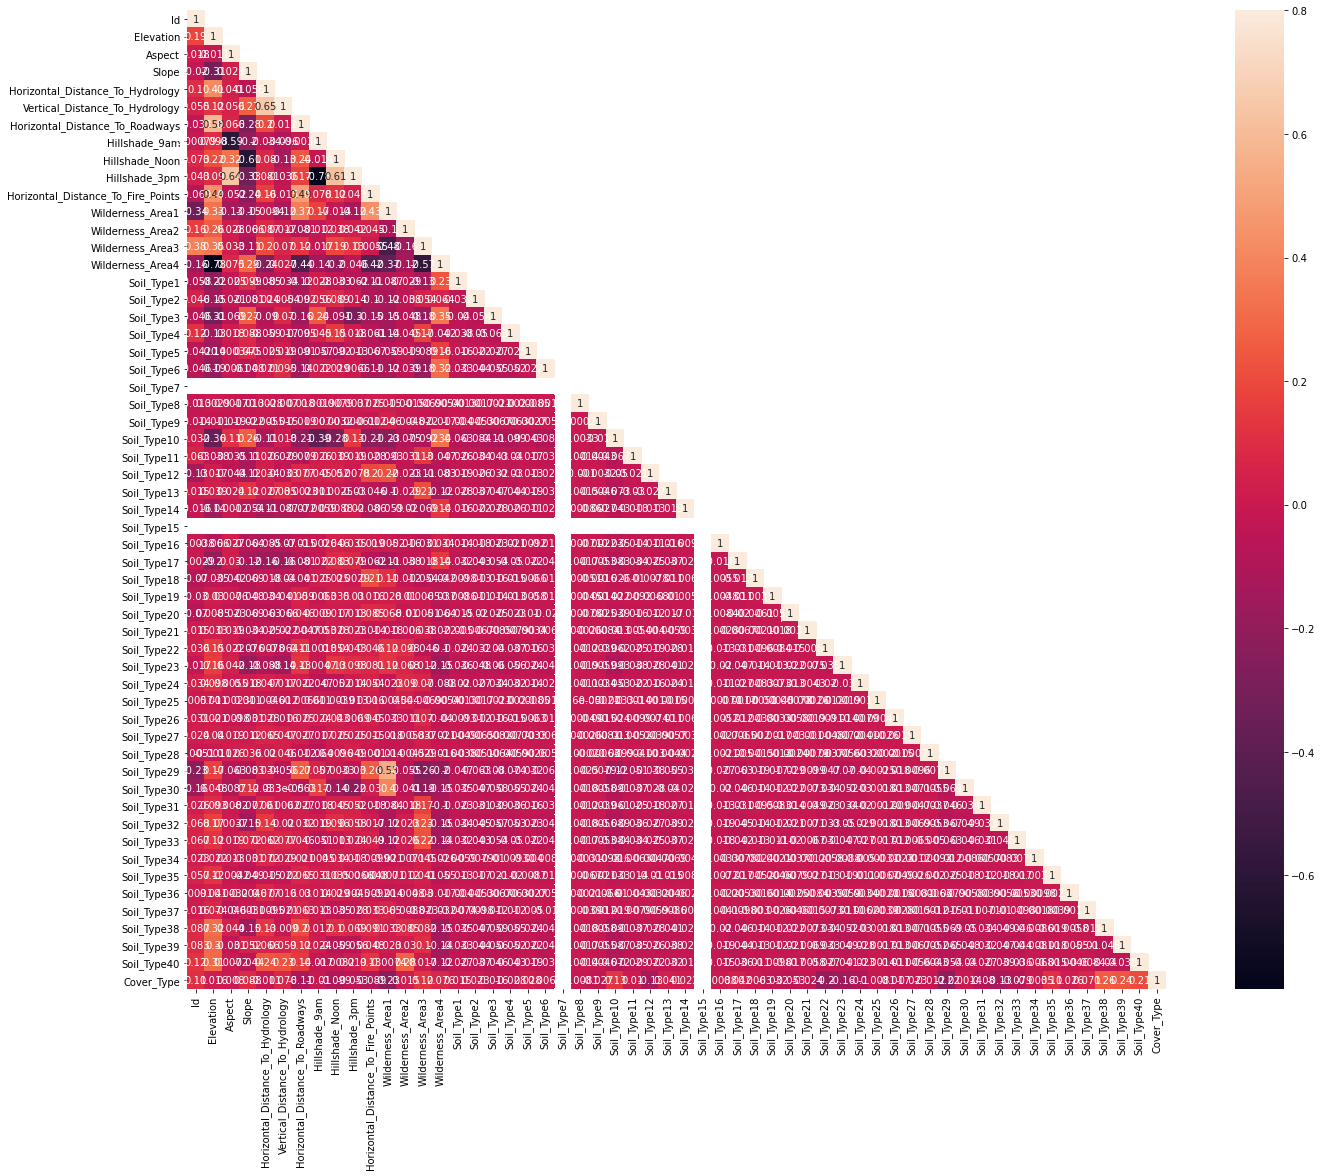

In [12]:
fig, ax = plt.subplots(figsize=(25,18))  
corrMatrix = df_train.corr()
mask=np.array(corrMatrix)
mask[np.tril_indices_from(mask)]=False
sns.heatmap(corrMatrix,mask=mask,vmax=0.8,square=True,annot=True,ax=ax)

plt.show()

In [13]:
size = 10 
data_size=df_train.iloc[:,:size] 
cols=data_size.columns 
data_corr = data_size.corr()
threshold = 0.5

corr_list = []

for i in range(0,size):
    for j in range(i+1,size):
        if (data_corr.iloc[i,j] >= threshold and data_corr.iloc[i,j] < 1) or (data_corr.iloc[i,j] < 0 and data_corr.iloc[i,j] <= -threshold):
            corr_list.append([data_corr.iloc[i,j],i,j])
           
s_corr_list = sorted(corr_list,key=lambda x: -abs(x[0]))

for v,i,j in s_corr_list:
    print ("%s and %s = %.2f" % (cols[i],cols[j],v))

Hillshade_9am and Hillshade_3pm = -0.78
Horizontal_Distance_To_Hydrology and Vertical_Distance_To_Hydrology = 0.65
Aspect and Hillshade_3pm = 0.64
Hillshade_Noon and Hillshade_3pm = 0.61
Slope and Hillshade_Noon = -0.61
Aspect and Hillshade_9am = -0.59
Elevation and Horizontal_Distance_To_Roadways = 0.58


---
### 2.3 Visualizations

#### 2.3.1 Pairplots of correlated variables

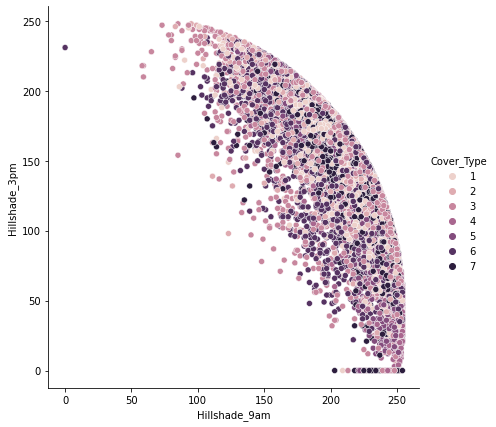

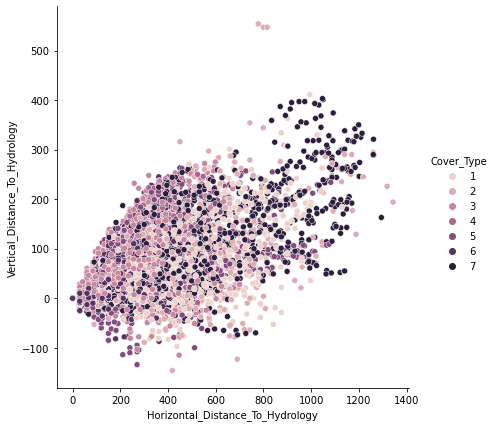

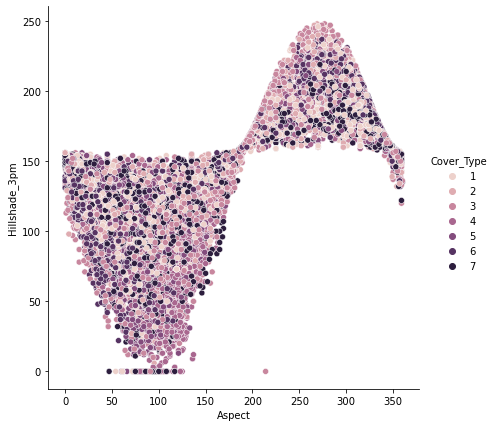

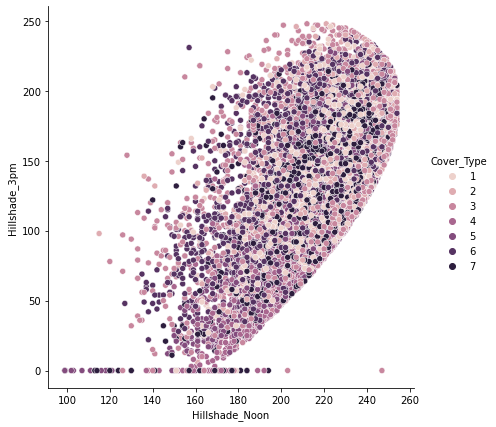

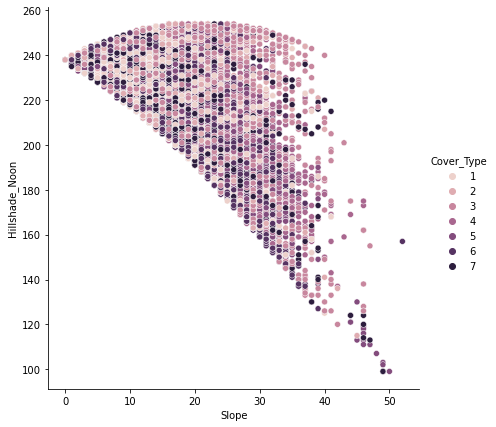

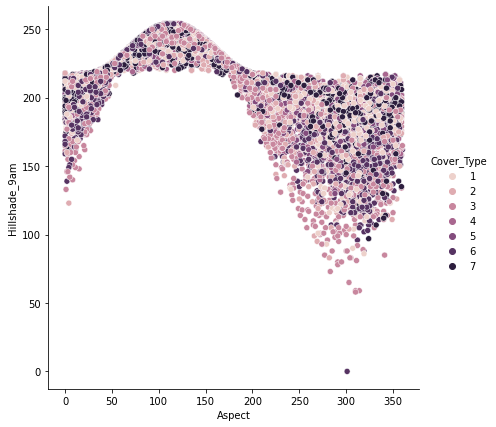

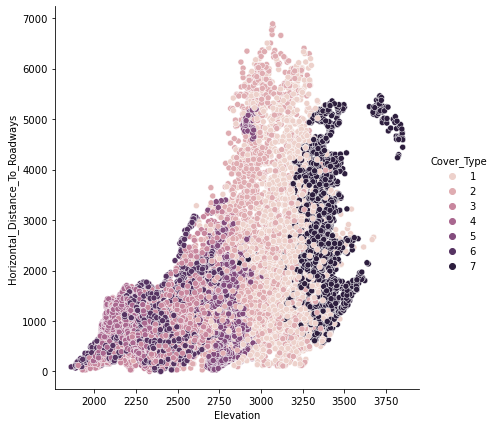

In [14]:
for v,i,j in s_corr_list:
    sns.pairplot(df_train, hue="Cover_Type", size=6, x_vars=cols[i],y_vars=cols[j] )
    plt.show()

#### 2.3.2 Violinplots of all features (excluding soil)

In [15]:
cols = df_train.columns
len(cols)

56

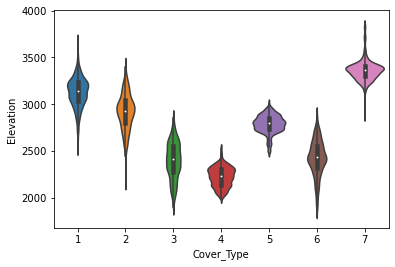

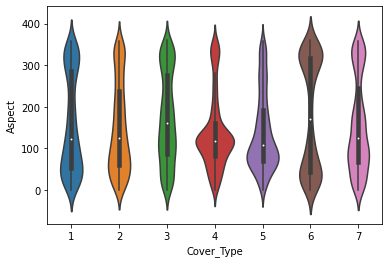

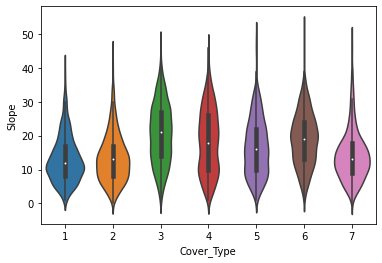

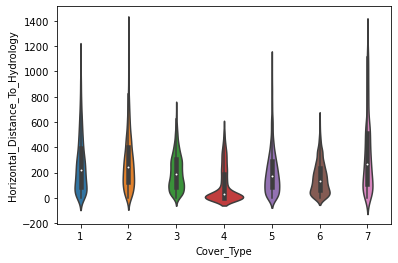

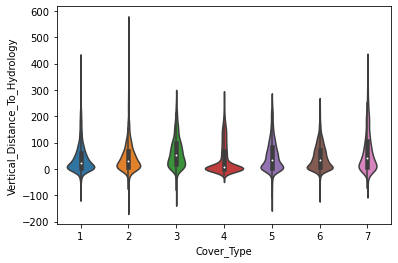

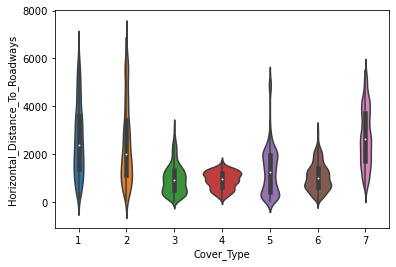

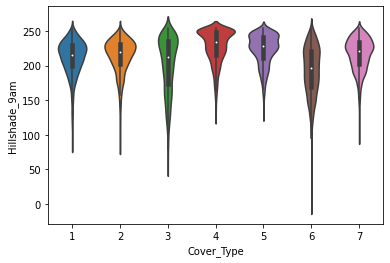

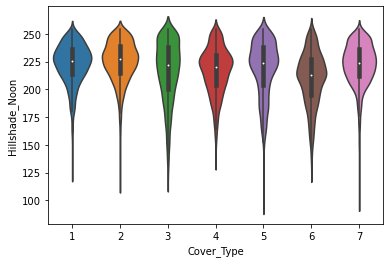

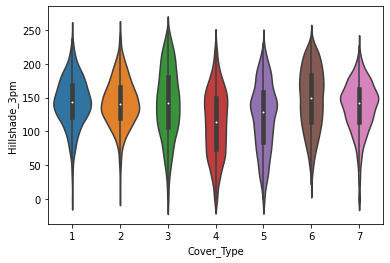

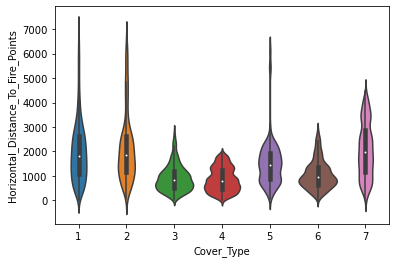

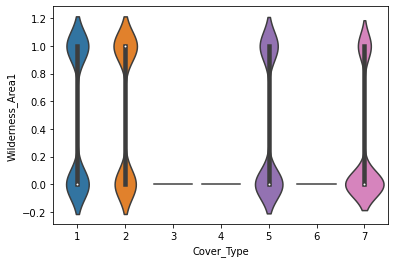

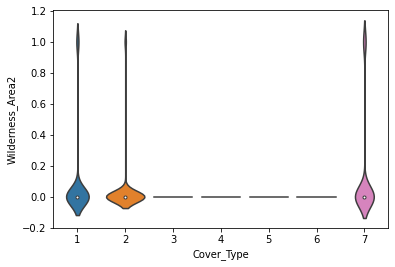

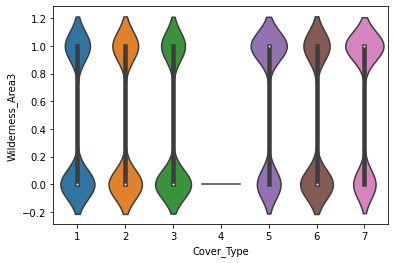

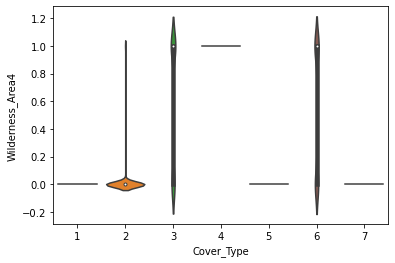

In [16]:
cols = df_train.columns
size = len(cols)-1
x = cols[size]
y = cols[0:size]

for i in range(1,size-40):
    sns.violinplot(data=df_train,x=x,y=y[i])  
    plt.show()

#### 2.3.2 Countplots for Wilderness_Area and Soil_Type distribution

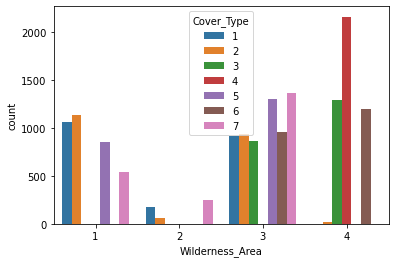

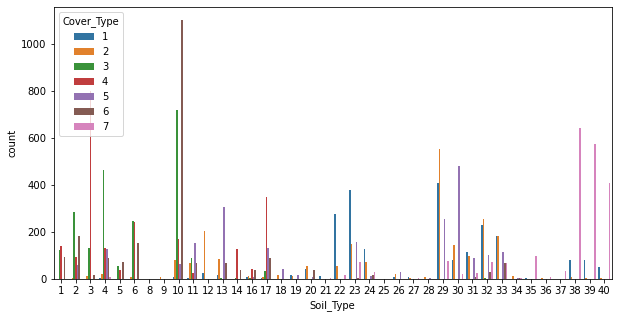

In [17]:
df_train_2 = df_train.drop(["Id"], axis = 1)
cols = df_train_2.columns
r,c = df_train_2.shape
data_2 = pd.DataFrame(index=np.arange(0, r),columns=['Wilderness_Area','Soil_Type','Cover_Type'])

for i in range(0,r):
    w=0;
    s=0;
    
    for j in range(10,14):
        if (df_train_2.iloc[i,j] == 1):
            w=j-9
            break
            
    for k in range(14,54):
        if (df_train_2.iloc[i,k] == 1):
            s=k-13
            break
            
    data_2.iloc[i]=[w,s,df_train_2.iloc[i,c-1]]

  
sns.countplot(x="Wilderness_Area", hue="Cover_Type", data=data_2)
plt.show()
plt.rc("figure", figsize=(10, 5))
sns.countplot(x="Soil_Type", hue="Cover_Type", data=data_2)
plt.show()

---
## 3. Data cleaning

---
### 3.1 Screening for missing values 

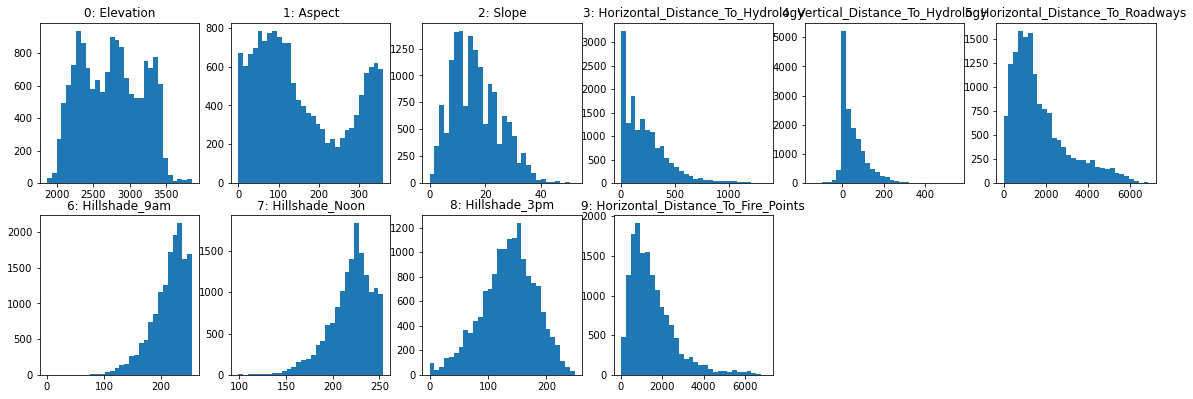

In [18]:
fig, axes = plt.subplots(3, 6, figsize=(20, 10))
for i, ax in enumerate(axes.ravel()):
    if i > 9:
        ax.set_visible(False)
        continue
    ax.hist(df_train.iloc[:, i+1], bins=30)
    ax.set_title("{}: {}".format(i, df_train.columns[i+1]))

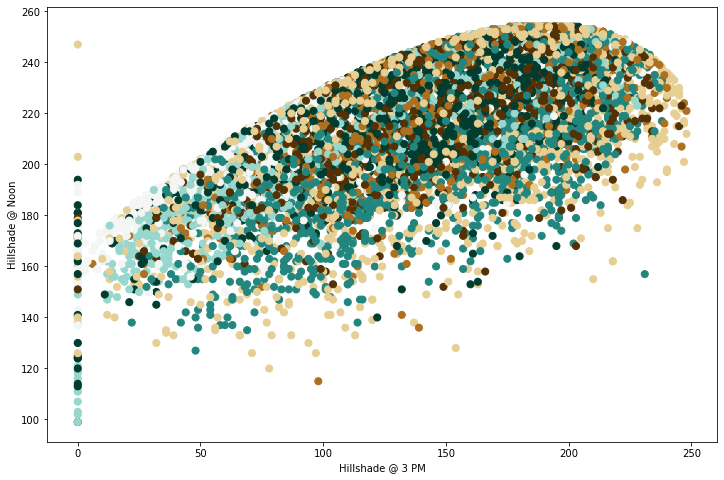

In [19]:
plt.figure(figsize=(12,8))
plt.scatter(df_train.Hillshade_3pm,df_train.Hillshade_Noon, c=df_train.Cover_Type, s=50, cmap=plt.cm.BrBG)
plt.xlabel('Hillshade @ 3 PM')
plt.ylabel('Hillshade @ Noon')
plt.show()

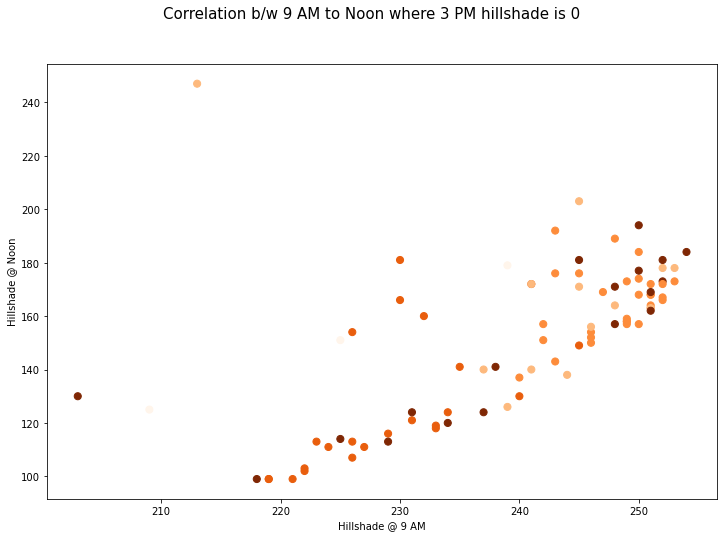

In [20]:
smaller_frame=df_train[df_train.Hillshade_3pm==0] 
plt.figure(figsize=(12,8))
plt.scatter(smaller_frame.Hillshade_9am,smaller_frame.Hillshade_Noon, c=smaller_frame.Cover_Type, s=50, cmap=plt.cm.Oranges)
plt.suptitle('Correlation b/w 9 AM to Noon where 3 PM hillshade is 0', fontsize=15)
plt.xlabel('Hillshade @ 9 AM')
plt.ylabel('Hillshade @ Noon')
plt.show()

---
### 3.2 Imputing missing values 

In [21]:
#Make a copy and Reorder train.csv columns
temp=df_train.copy()
cols=temp.columns.tolist()
cols=cols[:8]+cols[9:]+[cols[8]]
temp=temp[cols]

del temp['Cover_Type']

In [22]:
X,y,X_df_train_missing,y_df_train_missing= temp[temp.Hillshade_3pm!=0].values[:,:-1],\
temp[temp.Hillshade_3pm!=0].values[:,-1:].ravel(),\
temp[temp.Hillshade_3pm==0].values[:,:-1],\
temp[temp.Hillshade_3pm==0].values[:,-1:].ravel() 

X_train,X_test,y_train,y_test=train_test_split(X,y)

In [23]:
gbrt=GradientBoostingRegressor(n_estimators=1000) 
gbrt.fit(X_train,y_train)

GradientBoostingRegressor(n_estimators=1000)

In [24]:
print ('Training R-squared value: %.2f' %gbrt.score(X_train, y_train))
print ('Test R-squared value: %.2f' %gbrt.score(X_test, y_test))

Training R-squared value: 1.00
Test R-squared value: 1.00


In [25]:
temp.Hillshade_3pm.loc[temp.Hillshade_3pm==0]=gbrt.predict(X_df_train_missing)
df_train.Hillshade_3pm=temp.Hillshade_3pm

In [26]:
temp=df_test.copy()
cols=temp.columns.tolist()
cols=cols[:8]+cols[9:]+[cols[8]]
temp=temp[cols]

X_df_test_missing= temp[temp.Hillshade_3pm==0].values[:,:-1]
temp.Hillshade_3pm.loc[temp.Hillshade_3pm==0]=gbrt.predict(X_df_test_missing)
df_test.Hillshade_3pm=temp.Hillshade_3pm

---
### 3.3 Validating new inputs 

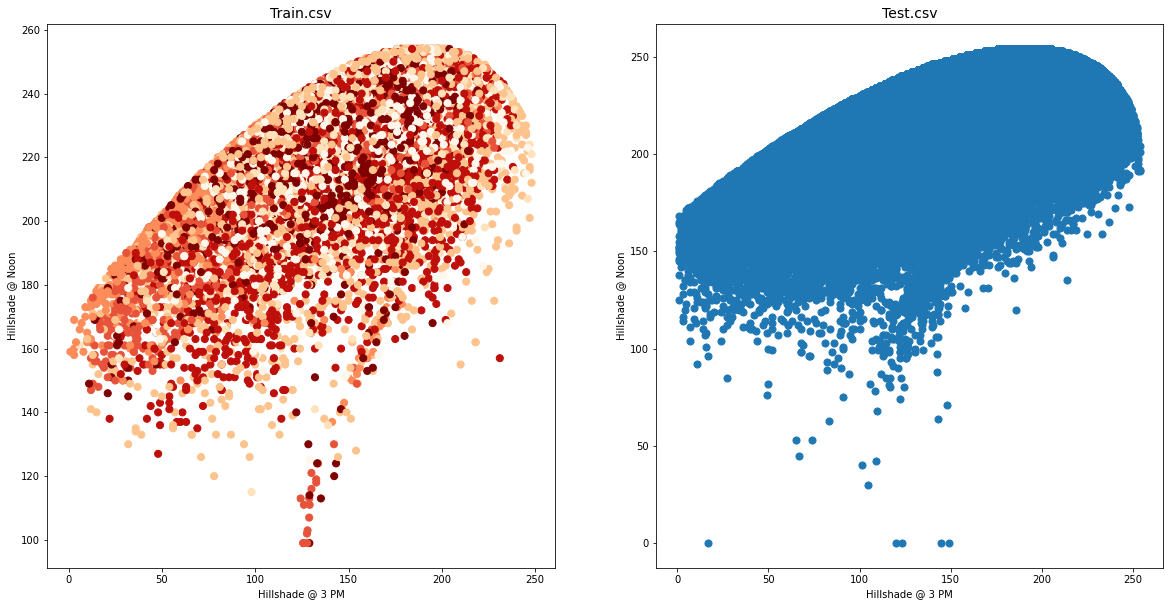

In [27]:
fig, ax=plt.subplots(1,2,figsize=(20,10)) 
ax[0].scatter(df_train.Hillshade_3pm,df_train.Hillshade_Noon, c=df_train.Cover_Type, s=50, cmap=plt.cm.OrRd)
ax[0].set_xlabel('Hillshade @ 3 PM')
ax[0].set_ylabel('Hillshade @ Noon')
ax[0].set_title('Train.csv', fontsize=14)
ax[1].scatter(df_test.Hillshade_3pm,df_test.Hillshade_Noon, s=50, cmap=plt.cm.PuBu)
ax[1].set_xlabel('Hillshade @ 3 PM')
ax[1].set_ylabel('Hillshade @ Noon')
ax[1].set_title('Test.csv', fontsize=14)
plt.show()

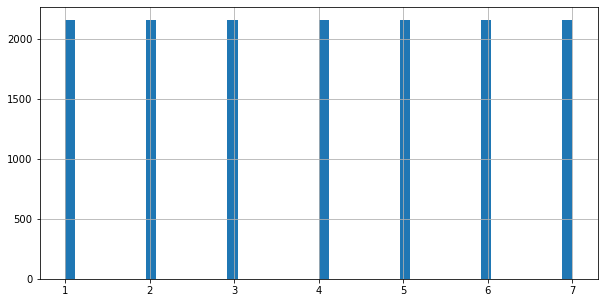

In [28]:
df_train.Cover_Type.hist(bins=50)
plt.show()

---
## 4. Feature Engineering

---
### 4.1 Define new features 

In [29]:
def add_feature(df_train):   
    df_train['Ele_minus_VDtHyd'] = df_train.Elevation-df_train.Vertical_Distance_To_Hydrology
    df_train['Ele_plus_VDtHyd'] = df_train.Elevation+df_train.Vertical_Distance_To_Hydrology
    df_train['Distance_to_Hydrolody'] = (df_train['Horizontal_Distance_To_Hydrology']**2+df_train['Vertical_Distance_To_Hydrology']**2)**0.5
    df_train['Hydro_plus_Fire'] = df_train['Horizontal_Distance_To_Hydrology']+df_train['Horizontal_Distance_To_Fire_Points']
    df_train['Hydro_minus_Fire'] = df_train['Horizontal_Distance_To_Hydrology']-df_train['Horizontal_Distance_To_Fire_Points']
    df_train['Hydro_plus_Road'] = df_train['Horizontal_Distance_To_Hydrology']+df_train['Horizontal_Distance_To_Roadways']
    df_train['Hydro_minus_Road'] = df_train['Horizontal_Distance_To_Hydrology']-df_train['Horizontal_Distance_To_Roadways']
    df_train['Fire_plus_Road'] = df_train['Horizontal_Distance_To_Fire_Points']+df_train['Horizontal_Distance_To_Roadways']
    df_train['Fire_minus_Road'] = df_train['Horizontal_Distance_To_Fire_Points']-df_train['Horizontal_Distance_To_Roadways']
    df_train['Elev_to_HD_Hyd']=df_train.Elevation - 0.2 * df_train.Horizontal_Distance_To_Hydrology 
    df_train['Elev_to_HD_Road']=df_train.Elevation - 0.05 * df_train.Horizontal_Distance_To_Roadways 
    df_train['Elev_to_VD_Hyd']=df_train.Elevation - df_train.Vertical_Distance_To_Hydrology 
    df_train['Mean_Amenities']=(df_train.Horizontal_Distance_To_Fire_Points + df_train.Horizontal_Distance_To_Hydrology + df_train.Horizontal_Distance_To_Roadways) / 3
    df_train['Mean_Fire_Hyd']=(df_train.Horizontal_Distance_To_Fire_Points + df_train.Horizontal_Distance_To_Hydrology) / 2 
    
    return df_train

---
### 4.2 Integrate features into dataset 

In [30]:
train = add_feature(df_train)
test = add_feature(df_test)

In [31]:
#Reorder train.csv columns
cols=train.columns.tolist()
cols=cols[:10]+cols[-14:]+cols[10:-14]
train=train[cols]

In [32]:
#Reorder test.csv columns 
cols=test.columns.tolist()
cols=cols[:10]+cols[-14:]+cols[10:-14]
test=test[cols]

---
## 5. Feature Scaling

---
### 5.1 Analyzing outliers 

In [33]:
def outlier_function(df, col_name):
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

In [34]:
df_train

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,Ele_minus_VDtHyd,Ele_plus_VDtHyd,Distance_to_Hydrolody,Hydro_plus_Fire,Hydro_minus_Fire,Hydro_plus_Road,Hydro_minus_Road,Fire_plus_Road,Fire_minus_Road,Elev_to_HD_Hyd,Elev_to_HD_Road,Elev_to_VD_Hyd,Mean_Amenities,Mean_Fire_Hyd
0,1,2596,51,3,258,0,510,221,232,148.0,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,2596,2596,258.000000,6537,-6021,768,-252,6789,5769,2544.4,2570.50,2596,2349.000000,3268.5
1,2,2590,56,2,212,-6,390,220,235,151.0,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,2596,2584,212.084889,6437,-6013,602,-178,6615,5835,2547.6,2570.50,2596,2275.666667,3218.5
2,3,2804,139,9,268,65,3180,234,238,135.0,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2739,2869,275.769832,6389,-5853,3448,-2912,9301,2941,2750.4,2645.00,2739,3189.666667,3194.5
3,4,2785,155,18,242,118,3090,238,238,122.0,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2667,2903,269.235956,6453,-5969,3332,-2848,9301,3121,2736.6,2630.50,2667,3181.000000,3226.5
4,5,2595,45,2,153,-1,391,220,234,150.0,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,2596,2594,153.003268,6325,-6019,544,-238,6563,5781,2564.4,2575.45,2596,2238.666667,3162.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,15116,2607,243,23,258,7,660,170,251,214.0,1282,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2600,2614,258.094944,1540,-1024,918,-402,1942,622,2555.4,2574.00,2600,733.333333,770.0
15116,15117,2603,121,19,633,195,618,249,221,91.0,1325,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2408,2798,662.354890,1958,-692,1251,15,1943,707,2476.4,2572.10,2408,858.666667,979.0
15117,15118,2492,134,25,365,117,335,250,220,83.0,1187,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2375,2609,383.293621,1552,-822,700,30,1522,852,2419.0,2475.25,2375,629.000000,776.0
15118,15119,2487,167,28,218,101,242,229,237,119.0,932,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2386,2588,240.260276,1150,-714,460,-24,1174,690,2443.4,2474.90,2386,464.000000,575.0


In [35]:
for i in df_train.columns[:11]:
    if outlier_function(df_train, i)[2] > 0:
        print("There are {} outliers in {}".format(outlier_function(df_train, i)[2], i))

There are 53 outliers in Horizontal_Distance_To_Hydrology
There are 49 outliers in Vertical_Distance_To_Hydrology
There are 3 outliers in Horizontal_Distance_To_Roadways
There are 7 outliers in Hillshade_9am
There are 20 outliers in Hillshade_Noon
There are 132 outliers in Horizontal_Distance_To_Fire_Points


---
### 5.2 Scaling features

#### 5.2.1 Feature overview without scaling

Without scaling some features show highly skewed histograms and outliers. 

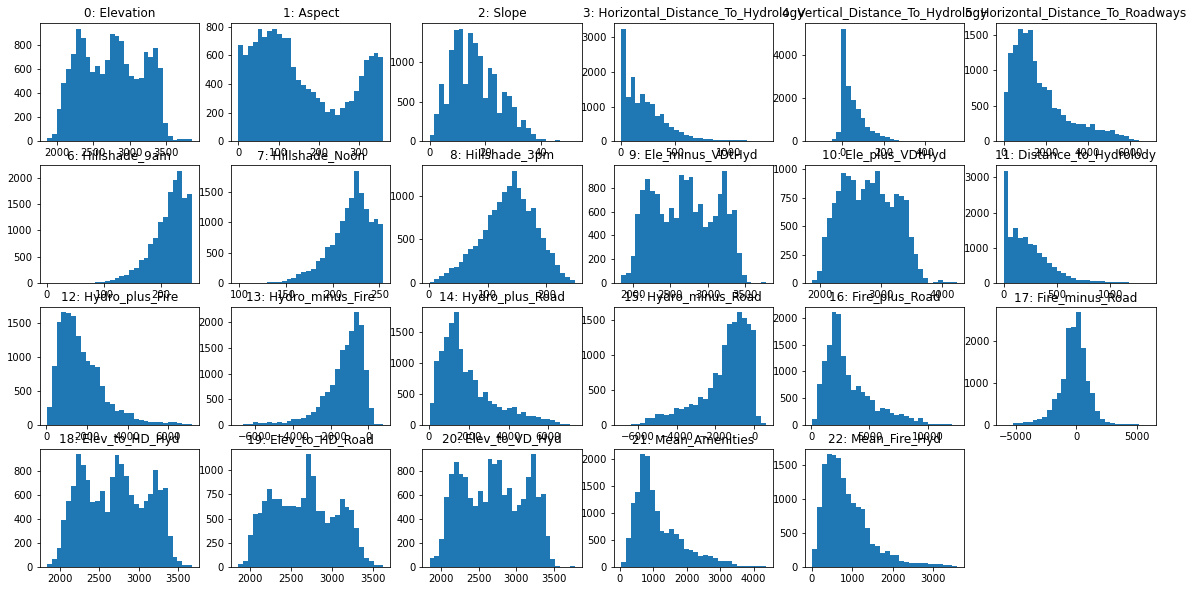

In [36]:
fig, axes = plt.subplots(4, 6, figsize=(20, 10))
for i, ax in enumerate(axes.ravel()):
    if i > 22:
        ax.set_visible(False)
        continue
    ax.hist(train.iloc[:, i+1], bins=30)
    ax.set_title("{}: {}".format(i, train.columns[i+1]))

<AxesSubplot:>

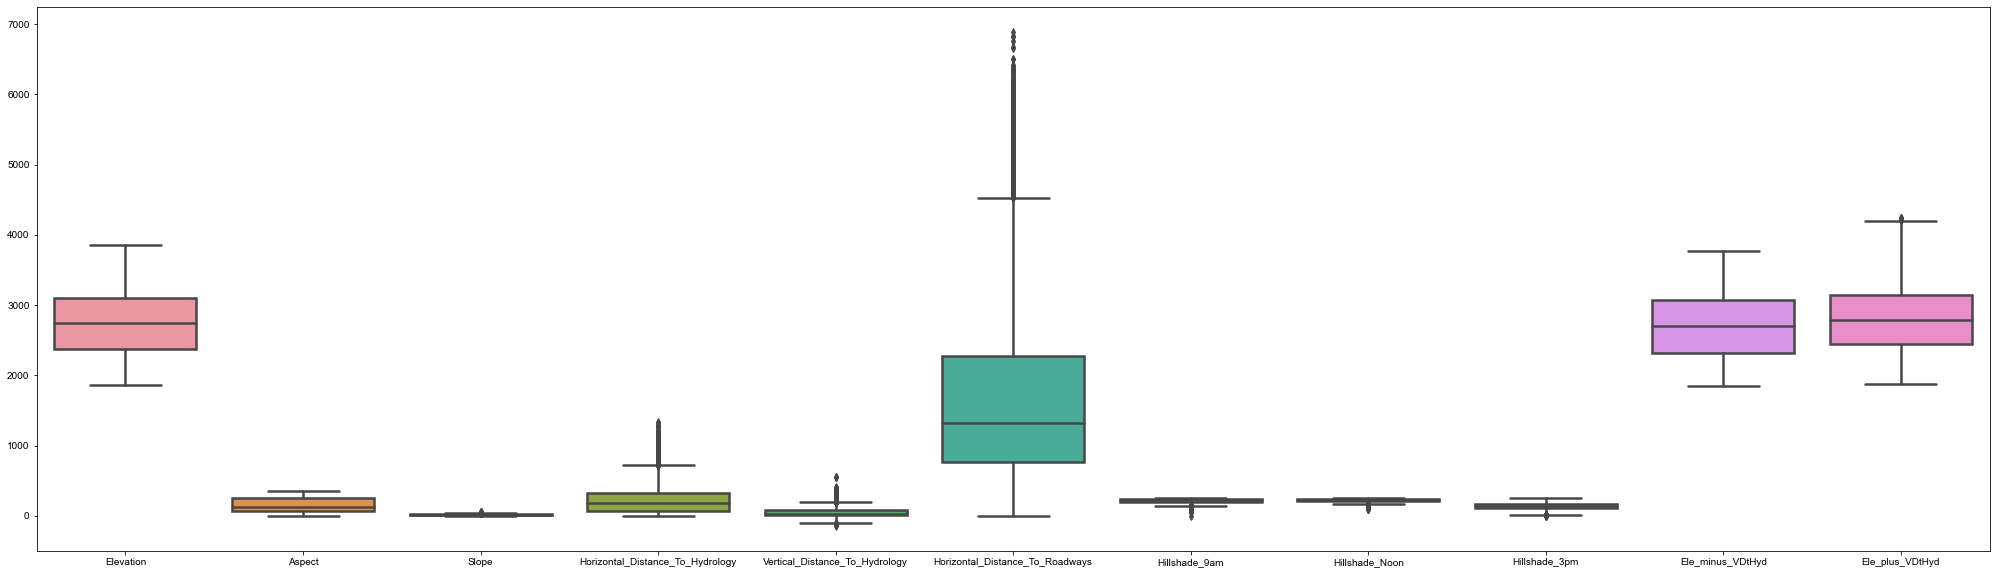

In [37]:
fig, axes = plt.subplots(1, figsize=(35, 10))
sns.set(style='whitegrid')
sns.boxplot(data=pd.DataFrame(data = train).iloc[:,1:12],linewidth=2.5)

#### 5.2.2 Feature overview with scaling

In [38]:
MMscaler = MinMaxScaler()
SSscaler = StandardScaler()
train_scaled = MMscaler.fit_transform(train.iloc[:,1:62])
test_scaled = MMscaler.fit_transform(test.iloc[:,1:62])

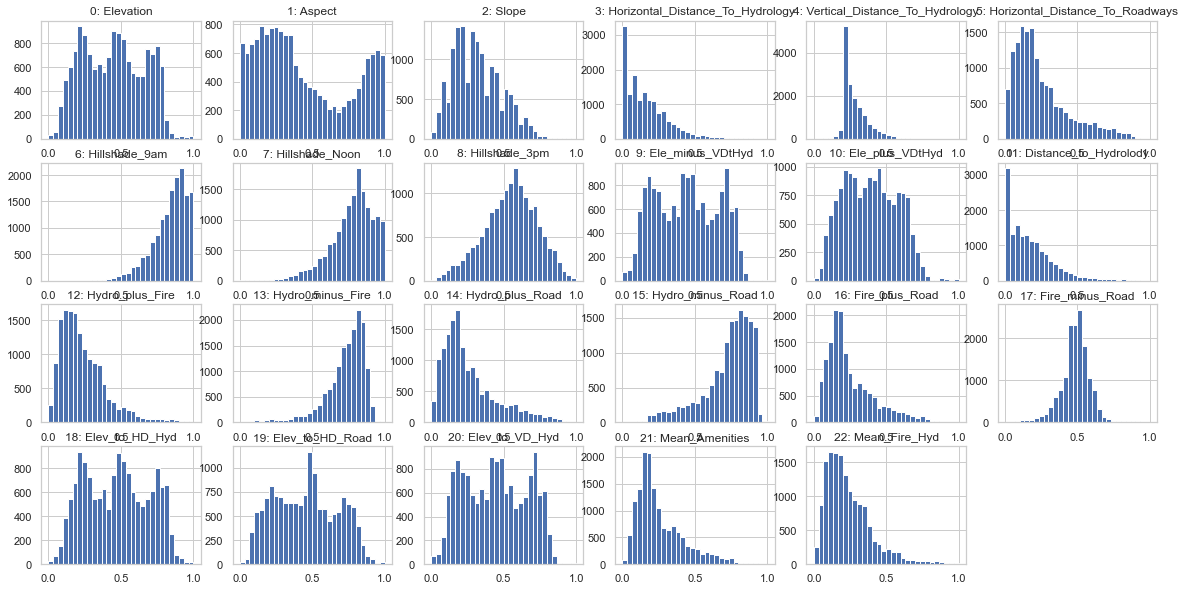

In [39]:
fig, axes = plt.subplots(4, 6, figsize=(20, 10))
for i, ax in enumerate(axes.ravel()):
    if i > 22:
        ax.set_visible(False)
        continue
    ax.hist(train_scaled[:, i], bins=30)
    ax.set_title("{}: {}".format(i, train.columns[i+1]))

<AxesSubplot:>

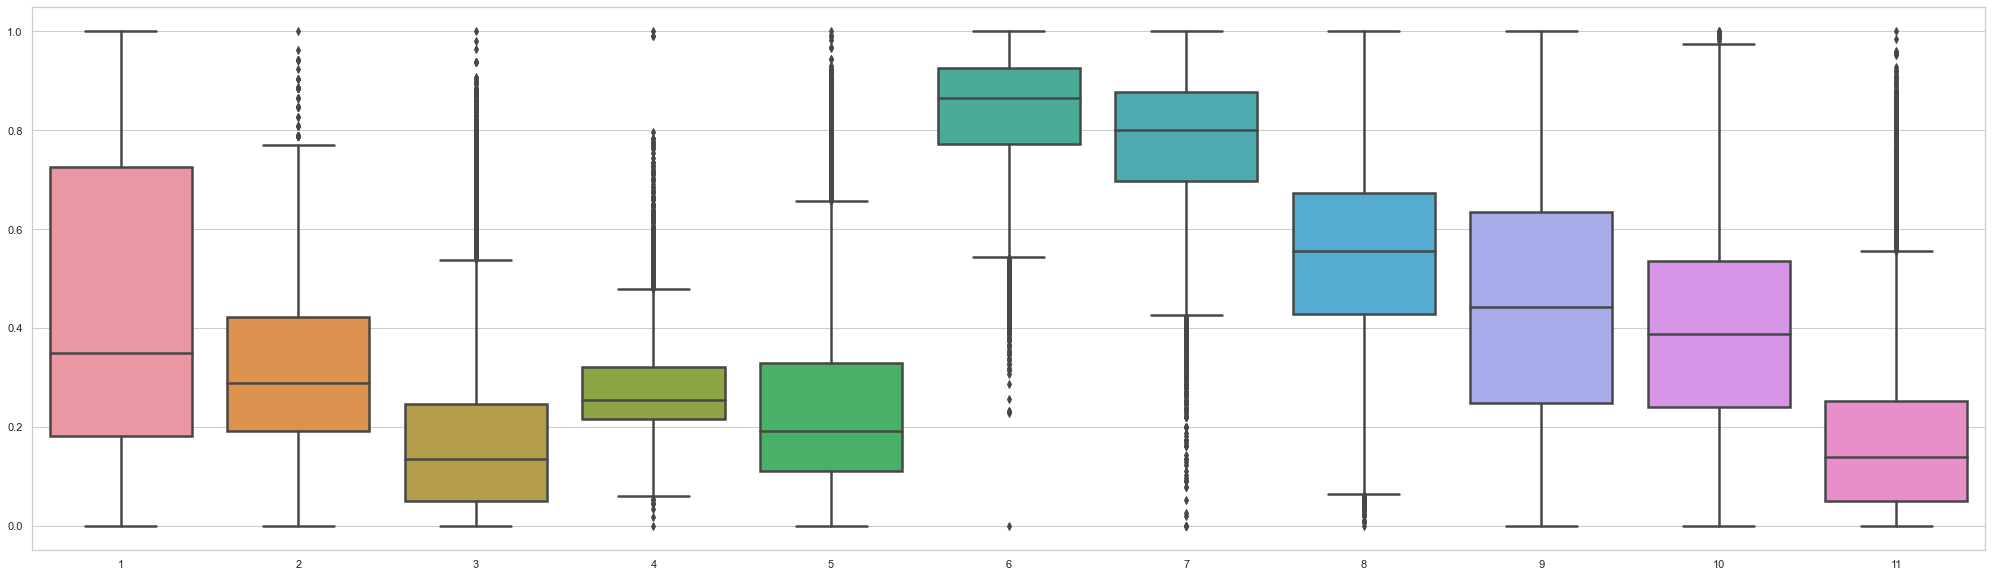

In [40]:
fig, axes = plt.subplots(1, figsize=(35, 10))
sns.set(style='whitegrid')
sns.boxplot(data=pd.DataFrame(data = train_scaled).iloc[:,1:12],linewidth=2.5)

---
### 5.3 Applying PowerTransformer 

In [41]:
pt = PowerTransformer()
train_pt = pt.fit_transform(train_scaled)

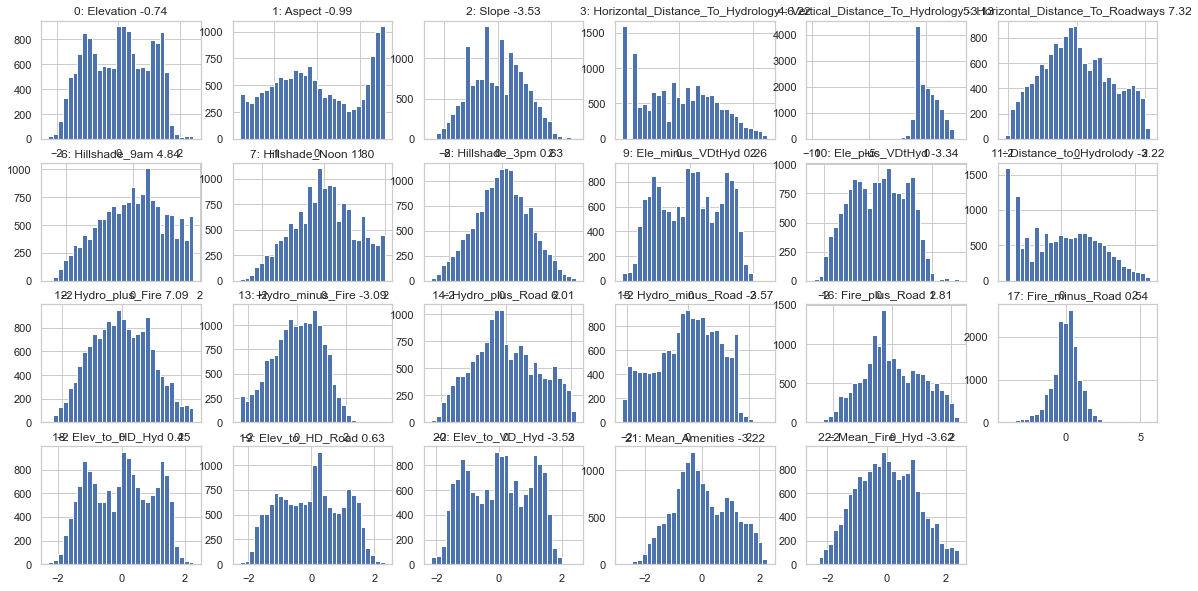

In [42]:
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

for i, ax in enumerate(axes.ravel()):
    if i > 22:
        ax.set_visible(False)
        continue
    ax.hist(train_pt[:, i], bins=30)
    ax.set_title("{}: {} {:.2f}".format(i, train.columns[i+1], pt.lambdas_[i+1]))

<AxesSubplot:>

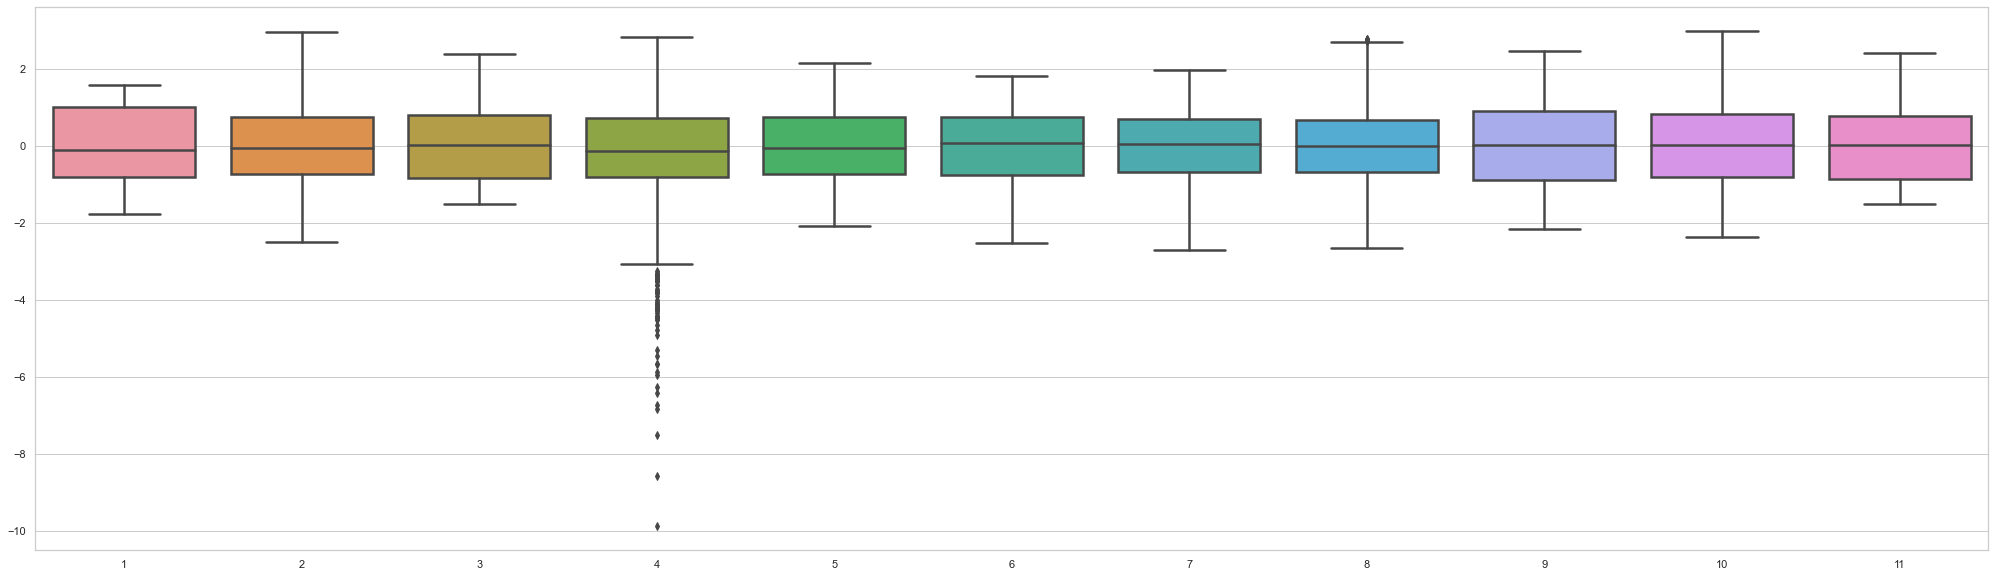

In [43]:
fig, axes = plt.subplots(1, figsize=(35, 10))
sns.set(style='whitegrid')
sns.boxplot(data=pd.DataFrame(data = train_pt).iloc[:,1:12],linewidth=2.5)

In [44]:
#train_pt = pd.DataFrame(data = train_pt, columns = train.iloc[:,1:62].keys())
#train_pt.head()

---
## 6. ML Predictive Analytics

---
### 6.1 Model setup

In [45]:
train.drop(['Id'], axis=1, inplace=True)
y = train.iloc[:, -1]
train = train.iloc[:, :-1]
test_Id = test.iloc[:, 0]
test.drop(['Id'], axis=1, inplace=True)

Drop columns?

In [46]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.1, shuffle= True)

---
### 6.2 Pipeline setup

In [47]:
sklearn.set_config(display="diagram")

In [48]:
numerical_pipeline = make_pipeline(
    RobustScaler(),
    PowerTransformer(), 
)

In [49]:
dirt_features = [col for col in train.columns if 'Soil' in col or "Wilderness" in col]

In [50]:
eng_features = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
                'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', "Ele_minus_VDtHyd", "Ele_plus_VDtHyd",
                "Distance_to_Hydrolody","Hydro_plus_Fire", "Hydro_minus_Fire", "Hydro_plus_Road", "Hydro_minus_Road", "Fire_plus_Road", "Fire_minus_Road",
                "Elev_to_HD_Hyd", "Elev_to_HD_Road", "Elev_to_VD_Hyd", "Mean_Amenities", "Mean_Fire_Hyd"]

ct = ColumnTransformer([
    ('scaler', numerical_pipeline,['Elevation', 
                                   'Aspect', 
                                   'Slope', 
                                   'Horizontal_Distance_To_Hydrology',
                                   'Vertical_Distance_To_Hydrology', 
                                   'Horizontal_Distance_To_Roadways',
                                   'Hillshade_9am',
                                   'Hillshade_Noon',
                                   'Hillshade_3pm',
                                   'Horizontal_Distance_To_Fire_Points',
                                   "Ele_minus_VDtHyd", "Ele_plus_VDtHyd",
                                   "Distance_to_Hydrolody","Hydro_plus_Fire",
                                   "Hydro_minus_Fire",
                                   "Hydro_plus_Road",
                                   "Hydro_minus_Road",
                                   "Fire_plus_Road",
                                   "Fire_minus_Road"]),
    ('pass_num','passthrough', dirt)
])

In [51]:
ct = ColumnTransformer([
    ('scaler', numerical_pipeline, eng_features),
    ('pass_num','passthrough', dirt_features)
])

In [52]:
clf = Pipeline([
    ("preprocessing", ct),
    ("classifier", ExtraTreesClassifier(n_estimators=400))
])
clf

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('scaler',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler()),
                                                                  ('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['Elevation', 'Aspect',
                                                   'Slope',
                                                   'Horizontal_Distance_To_Hydrology',
                                                   'Vertical_Distance_To_Hydrology',
                                                   'Horizontal_Distance_To_Roadways',
                                                   'Hillshade_9am',
                                                   'Hillshade_Noon',
                                                   'Hillshade_3pm',
                                                   'Hor...
                                                   'Soil_Type5', 'Soil_Type6',
                                                   'Soil_Type7', 'Soil_Type8',
                                                   'Soil_Type9', 'Soil_Type10',
                                                   'Soil_Type11', 'Soil_Type12',
                                                   'Soil_Type13', 'Soil_Type14',
                                                   'Soil_Type15', 'Soil_Type16',
                                                   'Soil_Type17', 'Soil_Type18',
                                                   'Soil_Type19', 'Soil_Type20',
                                                   'Soil_Type21', 'Soil_Type22',
                                                   'Soil_Type23', 'Soil_Type24',
                                                   'Soil_Type25', 'Soil_Type26', ...])])),
                ('classifier', ExtraTreesClassifier(n_estimators=400))])

In [53]:
# clf = make_pipeline(ct, ExtraTreesClassifier(n_estimators=400))

---
### 6.3 PCA

In [54]:
from sklearn.decomposition import PCA

pca_forest = PCA()

principalComponents_forest = pca_forest.fit_transform(train_scaled[:,1:62])

pd.DataFrame(principalComponents_forest).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
count,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04,1.512000e+04
mean,1.337160e-16,1.415314e-16,8.960902e-17,-4.209412e-17,-2.297912e-17,-1.152003e-16,-1.635413e-17,-3.516808e-17,-2.687491e-17,1.065432e-17,6.106594e-17,-7.217918e-18,1.421555e-17,8.726852e-18,-4.012810e-18,3.774354e-17,1.757853e-17,-2.623012e-17,-3.177688e-17,4.834739e-18,5.507059e-19,-1.966204e-17,-3.401985e-18,-1.432937e-17,1.681947e-19,-1.484703e-17,-1.113485e-17,-4.283574e-18,-2.563771e-17,-5.325326e-18,5.364793e-19,3.208780e-17,3.821394e-17,-2.805915e-17,-1.245628e-17,-6.803971e-18,-5.999367e-18,2.945817e-18,-7.132788e-19,3.792057e-17,-5.551826e-17,3.609831e-17,4.874249e-19,1.162118e-18,2.817081e-17,-4.596203e-17,1.243078e-16,3.177099e-17,3.439412e-17,-1.052534e-17,9.123302e-18,-3.374695e-18,-7.167828e-18,9.738453e-19,-1.502577e-18,-7.279688e-19,3.235982e-19,-1.425183e-18,1.059897e-18,-2.801251e-18
std,7.835153e-01,6.081424e-01,3.803671e-01,3.369235e-01,3.109366e-01,2.957763e-01,2.561979e-01,2.532102e-01,2.470174e-01,2.307970e-01,2.247900e-01,2.118753e-01,2.096425e-01,2.019403e-01,1.907189e-01,1.849509e-01,1.804100e-01,1.700319e-01,1.629716e-01,1.562585e-01,1.503704e-01,1.427397e-01,1.386562e-01,1.359636e-01,1.277257e-01,1.171097e-01,1.123395e-01,1.034600e-01,1.029775e-01,8.921774e-02,8.740331e-02,7.255629e-02,6.304012e-02,6.109290e-02,5.864358e-02,5.500770e-02,3.559020e-02,3.208067e-02,3.093526e-02,2.522334e-02,2.493420e-02,2.373080e-02,8.122121e-03,8.114386e-03,2.538873e-03,3.449015e-16,1.023245e-16,1.025092e-16,1.016423e-16,8.201878e-17,5.233917e-17,5.133733e-17,4.862004e-17,4.913594e-17,4.912261e-17,4.914020e-17,4.914452e-17,3.742332e-17,2.918922e-17,2.269843e-17
min,-1.479230e+00,-8.275505e-01,-8.539713e-01,-6.457874e-01,-1.077284e+00,-7.786737e-01,-9.293500e-01,-1.063223e+00,-6.559371e-01,-9.601293e-01,-5.105546e-01,-8.003014e-01,-5.728953e-01,-5.869392e-01,-6.353076e-01,-6.196004e-01,-4.806881e-01,-3.257779e-01,-5.309138e-01,-5.643085e-01,-7.017773e-01,-4.150326e-01,-5.002120e-01,-6.012863e-01,-4.536683e-01,-5.163738e-01,-4.265736e-01,-7.461497e-01,-4.739506e-01,-6.729762e-01,-2.568473e-01,-2.331810e-01,-4.755303e-01,-1.874136e-01,-6.408348e-01,-1.293221e-01,-1.229811e-01,-3.833293e-01,-1.555642e-01,-3.727404e-01,-2.938931e-01,-4.163455e-02,-6.089065e-01,-3.385135e-03,-6.398725e-03,-9.625024e-15,-2.642938e-15,-2.904501e-15,-2.348074e-15,-1.895027e-15,-1.516557e-15,-6.142371e-16,-1.185376e-15,-1.758807e-15,-8.767728e-16,-6.655634e-16,-3.391952e-16,-9.620296e-16,-1.076702e-15,-2.730624e-16
25%,-6.241294e-01,-6.064073e-01,-2.845699e-01,-2.287409e-01,-2.241822e-01,-1.934989e-01,-1.250903e-01,-1.549391e-01,-1.657589e-01,-1.148963e-01,-1.191498e-01,-7.768317e-02,-9.305041e-02,-7.388857e-02,-6.909088e-02,-1.080151e-01,-1.088861e-01,-7.258875e-02,-9.845725e-02,-5.600589e-02,-8.003043e-02,-1.050579e-01,-7.458711e-02,-5.085956e-02,-6.997947e-02,-6.467425e-02,-5.678576e-02,-1.881136e-02,-3.065854e-02,-2.232677e-02,-2.506448e-02,-4.582985e-02,-2.977608e-02,-2.629559e-02,-1.300851e-02,-9.230525e-03,-2.015735e-02,-5.199696e-03,-6.423498e-03,-4.690225e-03,-4.943657e-03,-6.166650e-03,-2.419

Text(0.8, 0.97, '95% confidence threshold')

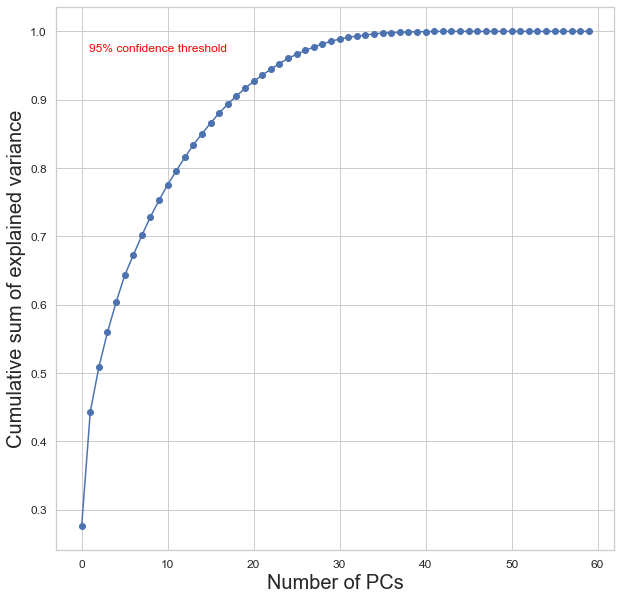

In [55]:
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(np.cumsum(pca_forest.explained_variance_ratio_), '-o')
plt.xlabel('Number of PCs', fontsize=20)
plt.ylabel('Cumulative sum of explained variance' , fontsize=20);
plt.axhline(y=0.95, color='red', linestyle='', linewidth=3)
plt.text(0.80, 0.97, '95% confidence threshold',color='red', fontsize = 12)

In [56]:
clf = Pipeline([
    ("preprocessing", ct),
    ("pca", PCA(n_components = 25)),
    ("classifier", ExtraTreesClassifier()),
])
clf

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('scaler',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler()),
                                                                  ('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['Elevation', 'Aspect',
                                                   'Slope',
                                                   'Horizontal_Distance_To_Hydrology',
                                                   'Vertical_Distance_To_Hydrology',
                                                   'Horizontal_Distance_To_Roadways',
                                                   'Hillshade_9am',
                                                   'Hillshade_Noon',
                                                   'Hillshade_3pm',
                                                   'Hor...
                                                   'Soil_Type7', 'Soil_Type8',
                                                   'Soil_Type9', 'Soil_Type10',
                                                   'Soil_Type11', 'Soil_Type12',
                                                   'Soil_Type13', 'Soil_Type14',
                                                   'Soil_Type15', 'Soil_Type16',
                                                   'Soil_Type17', 'Soil_Type18',
                                                   'Soil_Type19', 'Soil_Type20',
                                                   'Soil_Type21', 'Soil_Type22',
                                                   'Soil_Type23', 'Soil_Type24',
                                                   'Soil_Type25', 'Soil_Type26', ...])])),
                ('pca', PCA(n_components=25)),
                ('classifier', ExtraTreesClassifier())])

In [57]:
clf.set_params(**{"pca": None})

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('scaler',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler()),
                                                                  ('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['Elevation', 'Aspect',
                                                   'Slope',
                                                   'Horizontal_Distance_To_Hydrology',
                                                   'Vertical_Distance_To_Hydrology',
                                                   'Horizontal_Distance_To_Roadways',
                                                   'Hillshade_9am',
                                                   'Hillshade_Noon',
                                                   'Hillshade_3pm',
                                                   'Hor...
                                                   'Soil_Type5', 'Soil_Type6',
                                                   'Soil_Type7', 'Soil_Type8',
                                                   'Soil_Type9', 'Soil_Type10',
                                                   'Soil_Type11', 'Soil_Type12',
                                                   'Soil_Type13', 'Soil_Type14',
                                                   'Soil_Type15', 'Soil_Type16',
                                                   'Soil_Type17', 'Soil_Type18',
                                                   'Soil_Type19', 'Soil_Type20',
                                                   'Soil_Type21', 'Soil_Type22',
                                                   'Soil_Type23', 'Soil_Type24',
                                                   'Soil_Type25', 'Soil_Type26', ...])])),
                ('pca', None), ('classifier', ExtraTreesClassifier())])

---
### 6.4 Grid Search

In [58]:
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'pca', 'classifier', 'preprocessing__n_jobs', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose', 'preprocessing__scaler', 'preprocessing__pass_num', 'preprocessing__scaler__memory', 'preprocessing__scaler__steps', 'preprocessing__scaler__verbose', 'preprocessing__scaler__robustscaler', 'preprocessing__scaler__powertransformer', 'preprocessing__scaler__robustscaler__copy', 'preprocessing__scaler__robustscaler__quantile_range', 'preprocessing__scaler__robustscaler__unit_variance', 'preprocessing__scaler__robustscaler__with_centering', 'preprocessing__scaler__robustscaler__with_scaling', 'preprocessing__scaler__powertransformer__copy', 'preprocessing__scaler__powertransformer__method', 'preprocessing__scaler__powertransformer__standardize', 'classifier__bootstrap', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifi

#### 6.4.1 Testing impact of scaling/transforming on different models 

In [60]:
param_grid = [
    {
        "classifier": [LogisticRegression()],
        "classifier__random_state": [seed],
        "preprocessing__scaler__robustscaler" : [StandardScaler(),MinMaxScaler(), RobustScaler(), "passthrough"],
        "preprocessing__scaler__powertransformer" : [PowerTransformer(), "passthrough"],
        "pca" : [PCA(n_components = 25), "passthrough"],
        
    },
    {
        "classifier": [DecisionTreeClassifier()], 
        "classifier__random_state": [seed],
        "preprocessing__scaler__robustscaler" : [StandardScaler(),MinMaxScaler(), RobustScaler(), "passthrough"],
        "preprocessing__scaler__powertransformer" : [PowerTransformer(), "passthrough"],
        "pca" : [PCA(n_components = 25), "passthrough"],
    },
    {
        "classifier": [RandomForestClassifier()],
        "classifier__random_state": [seed],
        "preprocessing__scaler__robustscaler" : [StandardScaler(),MinMaxScaler(), RobustScaler(), "passthrough"],
        "preprocessing__scaler__powertransformer" : [PowerTransformer(), "passthrough"],
        "pca" : [PCA(n_components = 25), "passthrough"],
    },
    {
        "classifier": [ExtraTreesClassifier()],
        "classifier__random_state": [seed],
        "preprocessing__scaler__robustscaler" : [StandardScaler(),MinMaxScaler(), RobustScaler(), "passthrough"],
        "preprocessing__scaler__powertransformer" : [PowerTransformer(), "passthrough"],
        "pca" : [PCA(n_components = 25), "passthrough"],
    },
    {
        "classifier": [SVC()],
        "classifier__random_state": [seed],
        "preprocessing__scaler__robustscaler" : [StandardScaler(),MinMaxScaler(), RobustScaler(), "passthrough"],
        "preprocessing__scaler__powertransformer" : [PowerTransformer(), "passthrough"],
        "pca" : [PCA(n_components = 25), "passthrough"],
    },
    {
        "classifier": [AdaBoostClassifier()], 
        "classifier__random_state": [seed],
        "preprocessing__scaler__robustscaler" : [StandardScaler(),MinMaxScaler(), RobustScaler(), "passthrough"],
        "preprocessing__scaler__powertransformer" : [PowerTransformer(), "passthrough"],
        "pca" : [PCA(n_components = 25), "passthrough"],
    },
    {
        "classifier": [GradientBoostingClassifier()],
        "classifier__random_state": [seed],
        "preprocessing__scaler__robustscaler" : [StandardScaler(),MinMaxScaler(), RobustScaler(), "passthrough"],
        "preprocessing__scaler__powertransformer" : [PowerTransformer(), "passthrough"],
        "pca" : [PCA(n_components = 25), "passthrough"],
    }
]
param_grid

[{'classifier': [LogisticRegression()],
  'classifier__random_state': [49],
  'preprocessing__scaler__robustscaler': [StandardScaler(),
   MinMaxScaler(),
   RobustScaler(),
   'passthrough'],
  'preprocessing__scaler__powertransformer': [PowerTransformer(),
   'passthrough'],
  'pca': [PCA(n_components=25), 'passthrough']},
 {'classifier': [DecisionTreeClassifier()],
  'classifier__random_state': [49],
  'preprocessing__scaler__robustscaler': [StandardScaler(),
   MinMaxScaler(),
   RobustScaler(),
   'passthrough'],
  'preprocessing__scaler__powertransformer': [PowerTransformer(),
   'passthrough'],
  'pca': [PCA(n_components=25), 'passthrough']},
 {'classifier': [RandomForestClassifier()],
  'classifier__random_state': [49],
  'preprocessing__scaler__robustscaler': [StandardScaler(),
   MinMaxScaler(),
   RobustScaler(),
   'passthrough'],
  'preprocessing__scaler__powertransformer': [PowerTransformer(),
   'passthrough'],
  'pca': [PCA(n_components=25), 'passthrough']},
 {'classifi

param_grid = [
    {
        "extratreesclassifier": [ExtraTreesClassifier()],
        "extratreesclassifier__n_estimators": [400],
        "extratreesclassifier__random_state": [seed],
    },
    {
        "extratreesclassifier": [DecisionTreeRegressor()], 
        "extratreesclassifier__random_state": [seed],
    },
    {
        "extratreesclassifier": [RandomForestRegressor()],
        "extratreesclassifier__random_state": [seed],
    }
]
param_grid

In [61]:
gs = GridSearchCV(clf, param_grid=param_grid, n_jobs=-1, cv=5)
gs

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         Pipeline(steps=[('robustscaler',
                                                                                          RobustScaler()),
                                                                                         ('powertransformer',
                                                                                          PowerTransformer())]),
                                                                         ['Elevation',
                                                                          'Aspect',
                                                                          'Slope',
                                                                          'Horizontal_Distance_To_Hydrology',
                                                                          'Vertical_Distance_To_Hydrology',
                                                                          'Horizontal_Distance_To_Roadways',
                                                                          'Hillshade_9am',
                                                                          'Hillshad...
                          'preprocessing__scaler__robustscaler': [StandardScaler(),
                                                                  MinMaxScaler(),
                                                                  RobustScaler(),
                                                                  'passthrough']},
                         {'classifier': [GradientBoostingClassifier()],
                          'classifier__random_state': [49],
                          'pca': [PCA(n_components=25), 'passthrough'],
                          'preprocessing__scaler__powertransformer': [PowerTransformer(),
                                                                      'passthrough'],
                          'preprocessing__scaler__robustscaler': [StandardScaler(),
                                                                  MinMaxScaler(),
                                                                  RobustScaler(),
                                                                  'passthrough']}])

In [62]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         Pipeline(steps=[('robustscaler',
                                                                                          RobustScaler()),
                                                                                         ('powertransformer',
                                                                                          PowerTransformer())]),
                                                                         ['Elevation',
                                                                          'Aspect',
                                                                          'Slope',
                                                                          'Horizontal_Distance_To_Hydrology',
                                                                          'Vertical_Distance_To_Hydrology',
                                                                          'Horizontal_Distance_To_Roadways',
                                                                          'Hillshade_9am',
                                                                          'Hillshad...
                          'preprocessing__scaler__robustscaler': [StandardScaler(),
                                                                  MinMaxScaler(),
                                                                  RobustScaler(),
                                                                  'passthrough']},
                         {'classifier': [GradientBoostingClassifier()],
                          'classifier__random_state': [49],
                          'pca': [PCA(n_components=25), 'passthrough'],
                          'preprocessing__scaler__powertransformer': [PowerTransformer(),
                                                                      'passthrough'],
                          'preprocessing__scaler__robustscaler': [StandardScaler(),
                                                                  MinMaxScaler(),
                                                                  RobustScaler(),
                                                                  'passthrough']}])

In [63]:
# results = pd.DataFrame(gs.cv_results_)
results = pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__random_state,param_pca,param_preprocessing__scaler__powertransformer,param_preprocessing__scaler__robustscaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
56,5.785273,0.257514,0.239096,0.020122,ExtraTreesClassifier(random_state=49),49,passthrough,PowerTransformer(),StandardScaler(),{'classifier': ExtraTreesClassifier(random_sta...,0.894195,0.898237,0.903747,0.906652,0.895994,0.899765,0.004709,1
61,4.407300,0.165392,0.228765,0.019982,ExtraTreesClassifier(random_state=49),49,passthrough,passthrough,MinMaxScaler(),{'classifier': ExtraTreesClassifier(random_sta...,0.892359,0.897502,0.900441,0.902977,0.901507,0.898957,0.003756,2
60,4.358894,0.154802,0.225109,0.015634,ExtraTreesClassifier(random_state=49),49,passthrough,passthrough,StandardScaler(),{'classifier': ExtraTreesClassifier(random_sta...,0.892359,0.896767,0.901176,0.902977,0.901507,0.898957,0.003897,2
63,4.155566,0.052728,0.198991,0.007777,ExtraTreesClassifier(random_state=49),49,passthrough,passthrough,passthrough,{'classifier': ExtraTreesClassifier(random_sta...,0.892359,0.896767,0.901176,0.902977,0.901507,0.898957,0.003897,2
62,4.224019,0.159315,0.211143,0.023525,ExtraTreesClassifier(random_state=49),49,passthrough,passthrough,RobustScaler(),{'classifier': ExtraTreesClassifier(random_sta...,0.892359,0.896767,0.901176,0.902977,0.901507,0.898957,0.003897,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,5.725073,0.143075,0.171068,0.014303,AdaBoostClassifier(),49,passthrough,PowerTransformer(),RobustScaler(),"{'classifier': AdaBoostClassifier(), 'classifi...",0.342028,0.437179,0.358193,0.363837,0.357222,0.371691,0.033531,103
89,5.166139,0.120252,0.191749,0.050709,AdaBoostClassifier(),49,passthrough,PowerTransformer(),MinMaxScaler(),"{'classifier': AdaBoostClassifier(), 'classifi...",0.342028,0.437179,0.358193,0.363837,0.357222,0.371691,0.033531,103
88,5.483937,0.124906,0.161491,0.016717,AdaBoostClassifier(),49,passthrough,PowerTransformer(),StandardScaler(),"{'classifier': AdaBoostClassifier(), 'classifi...",0.342028,0.437179,0.358193,0.363837,0.357222,0.371691,0.033531,103
83,7.215153,0.236309,0.179167,0.050515,AdaBoostClassifier(),49,PCA(n_components=25),PowerTransformer(),passthrough,"{'classifier': AdaBoostClassifier(), 'classifi...",0.311536,0.319618,0.308964,0.306505,0.429989,0.335322,0.047538,111


#### 6.4.2 Testing hyperparameters for best performing model

In [64]:
# clf.get_params().keys()

In [86]:
clf.set_params(**{"preprocessing__scaler__robustscaler" : StandardScaler()})

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('scaler',
                                                  Pipeline(steps=[('robustscaler',
                                                                   StandardScaler()),
                                                                  ('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['Elevation', 'Aspect',
                                                   'Slope',
                                                   'Horizontal_Distance_To_Hydrology',
                                                   'Vertical_Distance_To_Hydrology',
                                                   'Horizontal_Distance_To_Roadways',
                                                   'Hillshade_9am',
                                                   'Hillshade_Noon',
                                                   'Hillshade_3pm',
                                                   'H...
                                                   'Soil_Type5', 'Soil_Type6',
                                                   'Soil_Type7', 'Soil_Type8',
                                                   'Soil_Type9', 'Soil_Type10',
                                                   'Soil_Type11', 'Soil_Type12',
                                                   'Soil_Type13', 'Soil_Type14',
                                                   'Soil_Type15', 'Soil_Type16',
                                                   'Soil_Type17', 'Soil_Type18',
                                                   'Soil_Type19', 'Soil_Type20',
                                                   'Soil_Type21', 'Soil_Type22',
                                                   'Soil_Type23', 'Soil_Type24',
                                                   'Soil_Type25', 'Soil_Type26', ...])])),
                ('pca', None), ('classifier', ExtraTreesClassifier())])

In [87]:
# Due to required computational power i only selected the optimal number of n_estimators based on the grid search results for the final version of this notebook.
# I also discarded the PCA i did earlier as it made the model less accurate
param_grid = [
{
        "classifier": [ExtraTreesClassifier()],
        # "classifier__max_depth": np.linspace(10, 20, num=10, dtype = int),
        "classifier__n_estimators": [386], # np.linspace(300, 450, num= 50, dtype = int),
        # "classifier__max_features": np.linspace(0.5, 1, num=5),
        "classifier__random_state": [seed],
}
]

In [88]:
gs = GridSearchCV(clf, param_grid=param_grid, n_jobs=-1, cv=5)
gs

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         Pipeline(steps=[('robustscaler',
                                                                                          StandardScaler()),
                                                                                         ('powertransformer',
                                                                                          PowerTransformer())]),
                                                                         ['Elevation',
                                                                          'Aspect',
                                                                          'Slope',
                                                                          'Horizontal_Distance_To_Hydrology',
                                                                          'Vertical_Distance_To_Hydrology',
                                                                          'Horizontal_Distance_To_Roadways',
                                                                          'Hillshade_9am',
                                                                          'Hillsh...
                                                                          'Soil_Type15',
                                                                          'Soil_Type16',
                                                                          'Soil_Type17',
                                                                          'Soil_Type18',
                                                                          'Soil_Type19',
                                                                          'Soil_Type20',
                                                                          'Soil_Type21',
                                                                          'Soil_Type22',
                                                                          'Soil_Type23',
                                                                          'Soil_Type24',
                                                                          'Soil_Type25',
                                                                          'Soil_Type26', ...])])),
                                       ('pca', None),
                                       ('classifier', ExtraTreesClassifier())]),
             n_jobs=-1,
             param_grid=[{'classifier': [ExtraTreesClassifier()],
                          'classifier__n_estimators': [386],
                          'classifier__random_state': [49]}])

In [89]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         Pipeline(steps=[('robustscaler',
                                                                                          StandardScaler()),
                                                                                         ('powertransformer',
                                                                                          PowerTransformer())]),
                                                                         ['Elevation',
                                                                          'Aspect',
                                                                          'Slope',
                                                                          'Horizontal_Distance_To_Hydrology',
                                                                          'Vertical_Distance_To_Hydrology',
                                                                          'Horizontal_Distance_To_Roadways',
                                                                          'Hillshade_9am',
                                                                          'Hillsh...
                                                                          'Soil_Type17',
                                                                          'Soil_Type18',
                                                                          'Soil_Type19',
                                                                          'Soil_Type20',
                                                                          'Soil_Type21',
                                                                          'Soil_Type22',
                                                                          'Soil_Type23',
                                                                          'Soil_Type24',
                                                                          'Soil_Type25',
                                                                          'Soil_Type26', ...])])),
                                       ('pca', None),
                                       ('classifier', ExtraTreesClassifier())]),
             n_jobs=-1,
             param_grid=[{'classifier': [ExtraTreesClassifier(n_estimators=386,
                                                              random_state=49)],
                          'classifier__n_estimators': [386],
                          'classifier__random_state': [49]}])

In [90]:
results = pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__n_estimators,param_classifier__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,11.170464,0.111117,0.61581,0.035245,"ExtraTreesClassifier(n_estimators=386, random_...",386,49,{'classifier': ExtraTreesClassifier(n_estimato...,0.89493,0.90338,0.903747,0.907019,0.897464,0.901308,0.004434,1


In [91]:
gs.best_params_

{'classifier': ExtraTreesClassifier(n_estimators=386, random_state=49),
 'classifier__n_estimators': 386,
 'classifier__random_state': 49}

---
### 6.5 Evaluation

In [92]:
gs.best_score_

0.9013081913038736

In [93]:
gs.best_estimator_.score(X_test, y_test)

0.9027777777777778

In [94]:
y_hat = gs.predict(X_test)

Best Model Report
Class Report:               precision    recall  f1-score   support

           1       0.86      0.80      0.83       208
           2       0.84      0.78      0.81       226
           3       0.90      0.91      0.90       216
           4       0.96      0.99      0.97       213
           5       0.92      0.98      0.95       228
           6       0.88      0.88      0.88       208
           7       0.95      0.99      0.97       213

    accuracy                           0.90      1512
   macro avg       0.90      0.90      0.90      1512
weighted avg       0.90      0.90      0.90      1512



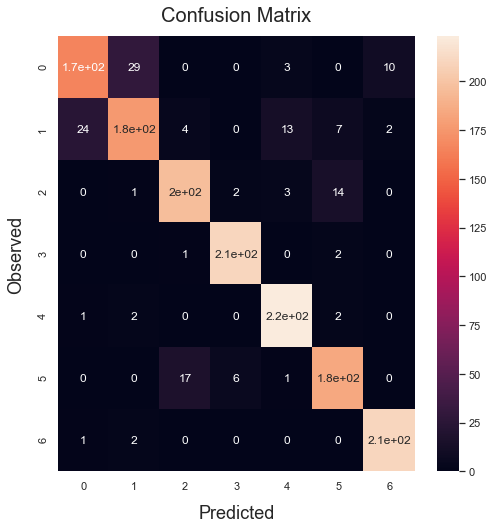

In [95]:
#Evaluating model with classification report and confusion matrix
class_report = classification_report(y_test, y_hat)
conf_matrix = confusion_matrix(y_test, y_hat)
acc_test = accuracy_score(y_test, y_hat)    # accuracy achieved on the test data

print(f"Best Model Report")       
print(f"Class Report: {class_report}")    

cm = confusion_matrix(y_test, y_hat)    
cm_df = pd.DataFrame(cm,
                     index = [0,1,2,3,4,5,6],
                     columns = [0,1,2,3,4,5,6])
plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True)
plt.title(f"Confusion Matrix", 
          size = 20, 
          pad = 15)
plt.ylabel("Observed", size = 18, labelpad = 13)
plt.xlabel("Predicted", size = 18, labelpad = 13)
plt.show()

---
### 6.6 Prediction

In [96]:
test_predictions = gs.predict(test)

In [97]:
solutions = pd.DataFrame({'Id': test_Id, 'Cover_Type': test_predictions})
solutions.to_csv('finsubmission_7.csv',index=False)